<span style='color:darkcyan'><font size="3">__Juan Sebastian Deslarzes__</font></span><br>
<span style='color:steelblue'><font size="3">__Chloé De Ancos__</font></span><br>
<span style='color:darkcyan'><font size="3">__Anaïs Burrus__</font></span><br>
<span style='color:darkcyan'><font size="3">__Margot Chapot__</font></span><br>
<span style='color:darkcyan'><font size="3">__Eva Sarlin__</font></span><br>

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as np
from skimage import io
from IPython import display
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import seaborn as sns
sns.set(color_codes=True)

Loading BokehJS ...

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import string

[nltk_data] Downloading package stopwords to /Users/epfl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<span style='color:mediumpurple'><font size="6">__Data Loading__</font></span><br>

In [3]:
sample_submission_url = 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/sample_submission.csv'
test_nolabel_url= 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/test_nolabel.csv'
train_url = 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/train.csv'

sample_submission = pd.read_csv(sample_submission_url)
test_nolabel = pd.read_csv(test_nolabel_url)
train = pd.read_csv(train_url)

<span style='color:mediumpurple'><font size="6">__Data Visualization__</font></span><br>

In [4]:
train.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


In [5]:
print('Data train dimensions : ', train.shape)
print('Unique values for label : ', train['label'].unique())
print("Number of unique values for statement: ", train['statement'].unique().size)
print("Number of unique values for subject: ", (train['subject'].unique()).size)
print("Number of unique values for speaker: ", (train['speaker'].unique()).size)
print("Number of unique values for speaker job: ", (train['speaker_job'].unique()).size)
print("Number of unique values for state information: ", (train['state_info'].unique()).size)
print("Number of unique values for party affiliation: ", (train['party_affiliation'].unique()).size)

Data train dimensions :  (8950, 8)
Unique values for label :  [1 0]
Number of unique values for statement:  8939
Number of unique values for subject:  3409
Number of unique values for speaker:  2634
Number of unique values for speaker job:  1092
Number of unique values for state information:  80
Number of unique values for party affiliation:  24


<AxesSubplot:xlabel='label', ylabel='party_affiliation'>

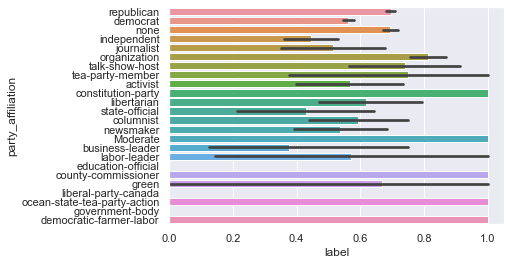

In [6]:
sns.barplot(x='label', y='party_affiliation', data=train)

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION DATA VISUALIZATION</b></font></span><br><br> <span style='color:black'> Donc en gros, on a un dataset de 8950 instances avec 8 colonnes. On peut y voir 7 features et 1 label/étiquette qui est la deuxième colonne "label". On doit rendre un un fichier submission avec les id et les label. L'objectif du challenge est donc de classifier en prédictant le label du fichier test_nolabel. On peut voir que la problème est le grand nombre de valeurs uniques pour une grande partie des attributs. Cela est du au fait que cette fois les valeurs des features sont du texte. L'objectif est donc de process ces valeurs textuelles pour pourvoir ensuite les uiliser avec des algo de machine learning. </span>
</div>

<span style='color:mediumpurple'><font size="6">__NLP algorithms (process les strings)__</font></span><br>

<span style='color:steelblue'><font size="3">__Avec le code du lab nlp (accuracy calculée sur le train)__</font></span><br>

In [7]:
X1 = train['statement'].values
X2 = train['subject'].values
X3 = train['speaker'].values
X4 = train['speaker_job'].values
X5 = train['state_info'].values
X6 = train['party_affiliation'].values
y = train['label'].values


X_test1 = test_nolabel['statement'].values
X_test2 = test_nolabel['subject'].values
X_test3 = test_nolabel['speaker'].values
X_test4 = test_nolabel['speaker_job'].values
X_test5 = test_nolabel['state_info'].values
X_test6 = test_nolabel['party_affiliation'].values

In [8]:
# Generic Transformer 
class GenericTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None):
        return do_something_to(X, self.vars)  # where the actual feature extraction happens

    def fit(self, X, y=None):
        return self  # used if the feature requires training, for example, clustering

In [9]:
class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='english')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]

In [10]:
def custom_tokenizer(words):
    """Preprocessing tokens as seen in the lexical notebook"""
    tokens = word_tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    stoplist = stopwords.words('english')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    return lemmas_punct

In [11]:
class PosStats(BaseEstimator, TransformerMixin):
    """Obtain number of tokens with POS categories"""

    def stats(self, doc):
        tokens = custom_tokenizer(doc)
        tagged = pos_tag(tokens, tagset='universal')
        counts = Counter(tag for word,tag in tagged)
        total = sum(counts.values())
        #copy tags so that we return always the same number of features
        pos_features = {'NOUN': 0, 'ADJ': 0, 'VERB': 0, 'ADV': 0, 'CONJ': 0, 
                        'ADP': 0, 'PRON':0, 'NUM': 0}
        
        pos_dic = dict((tag, float(count)/total) for tag,count in counts.items())
        for k in pos_dic:
            if k in pos_features:
                pos_features[k] = pos_dic[k]
        return pos_features
    
    def transform(self, docs, y=None):
        return [self.stats(doc) for doc in docs]
    
    def fit(self, docs, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

In [12]:
ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), encoding = 'ISO-8859-1', 
                                        tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

In [13]:
#effacer sûrement
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X[self.column]

In [14]:
pipeline1 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
         ('clf', MultinomialNB(alpha=.01))
    ])


pipeline1.fit(X1,y)
y_1 = pipeline1.predict(X1)
y_p1 = pipeline1.predict(X_test1)

# Using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline1, X1, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.60581006 0.59396648]
Accuracy: 0.60 (+/- 0.01)


In [15]:
pipeline2 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.01))
    ])


pipeline2.fit(X2,y)
y_p2 = pipeline2.predict(X_test2)
y_2=pipeline2.predict(X2)
# Using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline2, X2, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.5803352  0.58122905]
Accuracy: 0.58 (+/- 0.00)


In [16]:
pipeline3 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.01))
    ])


pipeline3.fit(X3,y)
y_p3 = pipeline3.predict(X_test3)
y_3=pipeline3.predict(X3)

# Using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline3, X3, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.62368715 0.60648045]
Accuracy: 0.62 (+/- 0.02)


In [ ]:
pipeline4 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.01))
    ])


pipeline4.fit(X4,y)
y_p4 = pipeline4.predict(X_test4)

#accuracy
#accuracy=metrics.accuracy_score(y, y_p4)
print(f'Accuracy of the testing set : {accuracy}')

In [ ]:
pipeline5 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.01))
    ])


pipeline5.fit(X5,y)
y_p5 = pipeline5.predict(X_test5)

# Using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline5, X5, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [17]:
pipeline6 = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       ('clf', MultinomialNB(alpha=.01))
    ])


pipeline6.fit(X6,y)
y_p6 = pipeline6.predict(X_test6)
y_6=pipeline6.predict(X6)

# Using KFold validation
cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline6, X6, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.60379888 0.6073743 ]
Accuracy: 0.61 (+/- 0.00)


In [31]:
y_p = np.zeros(3836);

for k in range(3836) :
    y_p[k] = 0.2*y_p1[k] + 0.1*y_p2[k] + 0.4*y_p3[k] + 0.3*y_p6[k]
    
    if y_p[k] >= 0.5 :
        y_p[k] = 1
    else :
        y_p[k]= 0

#y_predicted = y_p.astype(int)


In [20]:
#form 2D array which will be used to train perceptron
from scipy.sparse import csr_matrix
y_tt = np.array([y_1,y_2,y_3,y_6])
y_t = np.transpose(y_tt)
#y_m = csr_matrix(y_p)
print(y_t)
y_t.shape

[[1 1 1 1]
 [0 1 0 0]
 [0 0 0 0]
 ...
 [0 1 0 1]
 [1 0 1 1]
 [0 0 0 0]]


(8950, 4)

In [21]:
y.shape

(8950,)

In [22]:
#form 2D array which will be used to predict the labels using perceptron
from scipy.sparse import csr_matrix
y_pt = np.array([y_p1,y_p2,y_p3,y_p6])
y_p = np.transpose(y_pt)
print(y_p)
y_p.shape

[[1 1 0 0]
 [0 0 1 1]
 [1 1 1 1]
 ...
 [1 1 0 1]
 [1 0 1 1]
 [0 1 1 1]]


(3836, 4)

In [26]:
#a tester demain on a plus de chance
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors=15)
clf.fit(y_t,y)

y_predicted=clf.predict(y_p)

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

mlp = MLPClassifier(hidden_layer_sizes=(50,), alpha=1e-02 ,solver='lbfgs', random_state=1, max_iter=250)
mlp.fit(y_t, y)

y_predicted = mlp.predict(y_p)

<span style='color:steelblue'><font size="3">__Prédiction du test kaggle :__</font></span><br>

<span style='color:mediumpurple'><font size="6">__Feature Engineering__</font></span><br>

<span style='color:steelblue'><font size="5">__Statement Processing__</font></span><br>

<span style='color:steelblue'><font size="5">__Subject processing__</font></span><br>

<span style='color:steelblue'><font size="5">__Speaker features processing__</font></span><br>

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION DATA EXPLORING</b></font></span><br><br> <span style='color:black'> ici on écrit les conclusions, on peut même écrire en italique <i>voili </i>voilou. </span>
</div>

<span style='color:mediumpurple'><font size="6">__Machine Learning Algorithm__</font></span><br>

<span style='color:steelblue'><font size="5">__Ensemble Algos__</font></span><br>

<span style='color:steelblue'><font size="5">__Deep Learning__</font></span><br>

<span style='color:steelblue'><font size="5">__Genetic Algorithm__</font></span><br>

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION ALGORITHMS</b></font></span><br><br> <span style='color:black'> ici on écrit les conclusions, on peut même écrire en italique <i>voili </i>voilou. </span>
</div>

<span style='color:mediumpurple'><font size="6">__Prediction__</font></span><br>

<span style='color:mediumpurple'><font size="6">__Submission__</font></span><br>

In [27]:
id = test_nolabel['id']
dfsubmission = pd.DataFrame({'id': id, 'label': y_predicted}, columns=["id", "label"])
dfsubmission.to_csv('submission1.csv', index=False, header=True)

<div class="alert alert-block alert-info">
    <span style='color:purple'><font size="4"><b>CONCLUSION GENERALE</b></font></span><br><br> <span style='color:black'> ici on écrit les conclusions, on peut même écrire en italique <i>voili </i>voilou. </span>
</div>